# LA County Board of Supervisors - Campaign Donations Maps

These maps visualize campaign donations made in 2018 and 2019 to the candidates running for the Board of Supervisors, including races involving incumbents Kathryn Barger and Janice Hahn and one open seat being vacated by Mark Ridley-Thomas.  

In [22]:
import pandas as pd
import psycopg2 as pg
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import rc
%matplotlib inline
import seaborn as sns
import sqlalchemy
import pandas.io.sql as psql
import numpy as np
import geopandas 
import descartes
import geojson
import scheme
import mapclassify
import json
import pysal as ps
import jenkspy
import altair as alt
alt.renderers.enable('notebook')
alt.themes.enable('opaque')
import geopandas as gpd
import altair_latimes as lat
alt.themes.register('latimes', lat.theme)
alt.themes.enable('latimes')


ThemeRegistry.enable('latimes')

### Get the data from our larger donations database of committees in all countywide races back to 2007. 

In [23]:
database_con = pg.connect("dbname=campaigns user=postgres")

In [24]:
alldonations =  psql.read_sql("SELECT * FROM contributions WHERE 'Contributor Zip Code' != ''", database_con)

### Let's clean up the spaces and capitalization in field names

In [6]:
alldonations.columns = alldonations.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

In [7]:
alldonations.head(2)

,last_name,first_name,committee_id,committee_name,office_type,district_number,schedule,type,date,amount_rcvd,...,employer,int_name,int_city,int_state,int_zip_code,int_occupation,int_employer,doc_id,rec_id,x
0,Barger,Kathryn,1414462,Kathryn Barger for Supervisor 2020,CSU,C05,A,Other,2018-12-31,1500.0,...,,,,,,,,,2557,164858
1,Barger,Kathryn,1414462,Kathryn Barger for Supervisor 2020,CSU,C05,A,Other,2018-12-31,1500.0,...,,,,,,,,,2557,164916


### Some date parsing

In [8]:
alldonations['date'] = pd.to_datetime(alldonations['date'], errors='coerce')

In [9]:
alldonations['year'], alldonations['month'] = alldonations['date'].dt.year, alldonations['date'].dt.month
alldonations['year'] = alldonations['year'].astype(str)
alldonations['month'] = alldonations['month'].astype(str)
alldonations['amount_rcvd'] = alldonations['amount_rcvd'].astype(int)
alldonations['monthyear'] = pd.to_datetime(alldonations['date']).map(lambda dt: dt.replace(day=1))

### Filter out older contributions.

In [10]:
nudonations = alldonations[alldonations.date > '2018-06-30']
nudonations.head(3)

,last_name,first_name,committee_id,committee_name,office_type,district_number,schedule,type,date,amount_rcvd,...,int_state,int_zip_code,int_occupation,int_employer,doc_id,rec_id,x,year,month,monthyear
0,Barger,Kathryn,1414462,Kathryn Barger for Supervisor 2020,CSU,C05,A,Other,2018-12-31,1500,...,,,,,,2557,164858,2018,12,2018-12-01
1,Barger,Kathryn,1414462,Kathryn Barger for Supervisor 2020,CSU,C05,A,Other,2018-12-31,1500,...,,,,,,2557,164916,2018,12,2018-12-01
4,Wesson,Herb,1414475,Wesson for Supervisor 2020,CSU,C02,A,Other,2019-04-29,1500,...,,,,,,2581,167892,2019,4,2019-04-01


### Aggregate by month/year to make sure we filter appropriately. 

In [11]:
nudonations[['date', 'amount_rcvd']].groupby(nudonations.date.dt.to_period("M")).agg(['sum', 'size', 'mean'])

amount_rcvd                   
                sum  size         mean
date                                  
2018-07       87659   150   584.393333
2018-08      232188   323   718.848297
2018-09      304368   473   643.484144
2018-10      609077   803   758.501868
2018-11      176696   207   853.603865
2018-12      859396   700  1227.708571
2019-01      179180   187   958.181818
2019-02      607890   697   872.152080
2019-03      479805   509   942.642436
2019-04      419783   563   745.618117
2019-05      545495   706   772.655807
2019-06     1003559  1398   717.853362

## Three stories: Group 2020 contributions data by 1) race, 2) time, 3) zip code.

### Select only donations to candidates running in 2020

In [12]:
thiscycle = nudonations[(nudonations['date'] > '2018-06-30') & (nudonations['committee_name'].str.contains('2020', case = False)
)] 

In [13]:
thiscycle.groupby('committee_name').agg(['sum', 'size', 'mean'])

amount_rcvd       \
                                                           sum size   
committee_name                                                        
Committee to Re-Elect Jackie Lacey for District...      433480  444   
Holly J. Mitchell for County Supervisor 2020            564594  767   
JAN PERRY FOR SUPERVISOR 2020 DISTRICT 2                509760  893   
Janice Hahn for Supervisor 2020                         322850  275   
Jeong for County Supervisor 2020                         46100   82   
Joseph F. Iniguez for District Attorney 2020             48195  181   
Kathryn Barger for Supervisor 2020                      815095  935   
Wesson for Supervisor 2020                             1119445  960   

                                                                amount_pd  \
                                                           mean       sum   
committee_name                                                              
Committee to Re-Elect Jackie Lacey for District...   976.306306       0.0   
Holly J. Mitchell for County Supervisor 2020         736.106910       0.0   
JAN PERRY FOR SUPERVISOR 2020 DISTRICT 2             570.839866       0.0   
Janice Hahn for Supervisor 2020                     1174.000000       0.0   
Jeong for County Supervisor 2020                     562.195122       0.0   
Joseph F. Iniguez for District Attorney 2020         266.270718       0.0   
Kathryn Barger for Supervisor 2020                   871.759358       0.0   
Wesson for Supervisor 2020                          1166.088542       0.0   

                                                              
                                                   size mean  
committee_name                                                
Committee to Re-Elect Jackie Lacey for District...  444  0.0  
Holly J. Mitchell for County Supervisor 2020        767  0.0  
JAN PERRY FOR SUPERVISOR 2020 DISTRICT 2            893  0.0  
Janice Hahn for Supervisor 2020                     275  0.0  
Jeong for County Supervisor 2020                     82  0.0  
Joseph F. Iniguez for District Attorney 2020        181  0.0  
Kathryn Barger for Supervisor 2020                  935  0.0  
Wesson for Supervisor 2020                          960  0.0

In [14]:
thiscycle.head(3)

,last_name,first_name,committee_id,committee_name,office_type,district_number,schedule,type,date,amount_rcvd,...,int_state,int_zip_code,int_occupation,int_employer,doc_id,rec_id,x,year,month,monthyear
0,Barger,Kathryn,1414462,Kathryn Barger for Supervisor 2020,CSU,C05,A,Other,2018-12-31,1500,...,,,,,,2557,164858,2018,12,2018-12-01
1,Barger,Kathryn,1414462,Kathryn Barger for Supervisor 2020,CSU,C05,A,Other,2018-12-31,1500,...,,,,,,2557,164916,2018,12,2018-12-01
4,Wesson,Herb,1414475,Wesson for Supervisor 2020,CSU,C02,A,Other,2019-04-29,1500,...,,,,,,2581,167892,2019,4,2019-04-01


### 1) Create a dataframe with summary stats for each campaign this cycle

In [15]:
thiscycletotals = thiscycle.groupby(['first_name','last_name', 'committee_name'], as_index=False).agg({'amount_rcvd': ['size', 'mean', 'sum']}, as_index=False)

### 1) Clean up the hierarchical column structure. Standardize names in all caps.

In [16]:
flat_columns = [''.join(t) for t in thiscycletotals.columns]
thiscycletotals.columns = flat_columns
thiscycletotals['amount_rcvdmean'] = thiscycletotals['amount_rcvdmean'].astype(int)
thiscycletotals['amount_rcvdmean'] = thiscycletotals['amount_rcvdmean'].round(0)
thiscycletotals['last_name'] = thiscycletotals['last_name'].str.upper()
thiscycletotals['committee_name'] = thiscycletotals['committee_name'].str.upper()
thiscycletotals['first_name'] = thiscycletotals['first_name'].str.upper()

thiscycletotals

,first_name,last_name,committee_name,amount_rcvdsize,amount_rcvdmean,amount_rcvdsum
0,CHAN,JEONG,JEONG FOR COUNTY SUPERVISOR 2020,82,562,46100
1,HERB,WESSON,WESSON FOR SUPERVISOR 2020,960,1166,1119445
2,HOLLY J.,MITCHELL,HOLLY J. MITCHELL FOR COUNTY SUPERVISOR 2020,767,736,564594
3,JAN,PERRY,JAN PERRY FOR SUPERVISOR 2020 DISTRICT 2,893,570,509760
4,JACQUELYN,LACEY,COMMITTEE TO RE-ELECT JACKIE LACEY FOR DISTRIC...,444,976,433480
5,JANICE,HAHN,JANICE HAHN FOR SUPERVISOR 2020,275,1174,322850
6,JOSEPH F.,INIGUEZ,JOSEPH F. INIGUEZ FOR DISTRICT ATTORNEY 2020,181,266,48195
7,KATHRYN,BARGER,KATHRYN BARGER FOR SUPERVISOR 2020,935,871,815095


***

## Where did the donations come from? 

### Data frames for each candidate in the supervisors races

In [17]:
bargerall = thiscycle[(thiscycle.last_name == 'Barger')]
hahnall = thiscycle[(thiscycle.last_name == 'Hahn')]
perryall = thiscycle[(thiscycle.last_name == 'PERRY')]
wessonall = thiscycle[(thiscycle.last_name == 'Wesson')]
iniguezall = thiscycle[(thiscycle.last_name == 'Iniguez')]
jeongall = thiscycle[(thiscycle.last_name == 'Jeong')]
mitchellall = thiscycle[(thiscycle.last_name == 'Mitchell')]

### Load our spatial data

In [18]:
#CA zip codes
calizipsmap = gpd.read_file("/Users/mhustiles/Desktop/data/GIS/californiazips_simple.json")

#CA state boundary
calimap = gpd.read_file("/Users/mhustiles/Desktop/data/GIS/california.shp")

#LA County zip codes
# lazipsmap = gpd.read_file("/Users/mhustiles/Desktop/data/GIS/LA/la_county_gis_zipcodes/la_county_zipcodes.geojson")

#LA County zip codes
lazipsmap = gpd.read_file("/Users/mhustiles/Desktop/data/GIS/LA/la_county_gis_zipcodes/la_county_zipcodes_simple.json")

In [19]:
lazipsmap.crs
lazipsmapproj = lazipsmap.to_crs(epsg=4326)

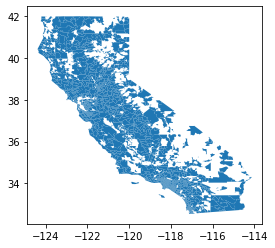

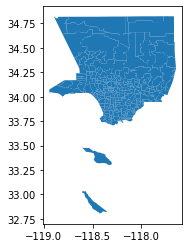

In [20]:
calizipsmap.plot()
lazipsmapproj.plot()

### Clean up field names

In [26]:
calizipsmaptrim = calizipsmap[[
    'ZCTA5CE10',
    'INTPTLAT10',
    'INTPTLON10',
    'geometry',
]].rename(columns={
    'ZCTA5CE10': "zip_code",
    'INTPTLAT10': "lat",
    'INTPTLON10': "lon",
    'geometry': "geometry",
})

lazipsmaptrim = lazipsmapproj[[
    'Shape.area',
    'Shape.len',
    'OBJECTID',
    'ZIPCODE',
    'geometry'
]].rename(columns={
    'Shape.area': "area",
    'Shape.len': "len",
    'OBJECTID': "ID",
    'ZIPCODE': "zip_code",
    'geometry': "geometry",
})

## Get rid of that silly island

,area,len,ID,zip_code,geometry
0,191184.208318,1801.702222,180,91046,POLYGON ((-118.2401427496653 34.21173137965621...
1,485596.910406,3122.780185,1547,90802,POLYGON ((-118.1794699104521 33.75926636656992...


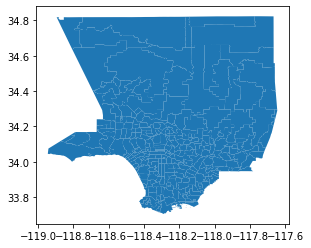

In [27]:
nulazipsmap = lazipsmaptrim[lazipsmaptrim.zip_code != '90704']
nulazipsmap.plot()
nulazipsmap.head(2)

In [56]:
lazips_grouped = nulazipsmap.groupby(['zip_code', 'ID'])

lazips_grouped.sum().reset_index().to_csv('/Users/mhustiles/Desktop/github/la-supervisors-donations-2020/data/lazips_grouped.csv')

***

### Aggregates for zip codes (removing null zips, cleaning up index headers, mean formatting, etc.)

In [ ]:
thiscyclezips = thiscyclezips[thiscyclezips.contributor_zip_code != ""]

thiscyclezips = thiscycle.groupby(['contributor_zip_code','last_name', 'committee_name'], as_index=False).agg({'amount_rcvd': ['size', 'mean', 'sum']}, as_index=False)

flat_columns = [''.join(t) for t in thiscyclezips.columns]
thiscyclezips.columns = flat_columns
thiscyclezips['amount_rcvdmean'] = thiscyclezips['amount_rcvdmean'].astype(int)
thiscyclezips['amount_rcvdmean'] = thiscyclezips['amount_rcvdmean'].round(2)
thiscyclezips['last_name'] = thiscyclezips['last_name'].str.upper()
thiscyclezips['committee_name'] = thiscyclezips['committee_name'].str.upper()

thiscyclezips

### Merge campaign data with zip code maps

In [ ]:
merged = nulazipsmap.merge(
    thiscyclezips[['contributor_zip_code', "amount_rcvdsum", "amount_rcvdsize", "amount_rcvdmean", "last_name"]],
    left_on="zip_code",
    right_on="contributor_zip_code"
)

In [ ]:
merged

In [ ]:
alt.themes.register('latimes', lat.theme)
alt.themes.enable('latimes')

In [ ]:
alt.data_transformers.enable('json')

In [ ]:
%matplotlib inline

In [ ]:
merged.head(3)

In [ ]:
mergedsupes.columns.tolist()

In [ ]:
mergedsupestrim = mergedsupes[[
    'Shape.area',
    'Shape.len',
    'OBJECTID',
    'ZIPCODE',
    'geometry',
    'contributor_zip_code',
    'last_name',
    'amount_rcvdsize',
    'amount_rcvdmean',
    'amount_rcvdsum',
]].rename(columns={
    'Shape.area': "area",
    'Shape.len': "len",
    'OBJECTID': "id",
    'ZIPCODE': "zipcode",
    'geometry': "geometry",
    'contributor_zip_code': "contributor_zip_code",
    'last_name': "candidate",
    'amount_rcvdsize': "amount_cnt",
    'amount_rcvdmean': "amount_avg",
    'amount_rcvdsum': "amount_sum",
})

In [ ]:
mergedsupestrim.dtypes

In [ ]:
mergedsupes.dtypes

In [ ]:
mergedsupestrim.plot()

In [ ]:
breaks = jenkspy.jenks_breaks((thiscyclezips.amount_rcvdsum), nb_class=7)

In [ ]:
breaks

In [ ]:
mergedsupestrim

In [ ]:
def get_group(value):
    for i, b in enumerate(breaks):
        if value <= breaks[i+1]:
            return i

In [ ]:
mergedsupestrim['amount_group'] = mergedsupestrim.amount_sum.apply(get_group)

In [ ]:
mergedsupestrim.head(5)

In [ ]:
mergedsupestrim.to_file("/Users/mhustiles/Desktop/mergedsupesdonationszips.geojson", driver="GeoJSON")

In [ ]:
geojson = json.loads(mergedsupestrim.to_json())

In [ ]:
features = alt.Data(values=geojson['features'])

In [ ]:
base = alt.Chart(features).mark_geoshape(
    stroke='white',
    strokeWidth=0.1
).encode().properties(
    width=600,
    height=600
)

In [ ]:
geoshape = alt.Chart(features).mark_geoshape(
    fill='lightgray',
    stroke='white'
)

In [ ]:
outcome = geoshape.encode(
    color=alt.Color(
        "properties.amount_group:N",
        scale=alt.Scale(
            domain=[0, 1, 2, 3, 4, 5, 6],
            range=lat.palette['schemes']['fire-7']
        ),
        legend=None
    )
)

In [ ]:
(base + outcome).properties(title="Totals by zip").configure_view(
    strokeWidth=0
)